#**PRODUCT SALES FORECASTING**


**Problem Statement**

In the competitive retail industry, the ability to predict future sales accurately is crucial for operational and strategic planning. Product sales forecasting aims to estimate the number of products a store will sell in the future, based on various influencing factors such as store type, location, regional characteristics, promotional activities, and temporal variations (such as holidays and seasons). This project focuses on developing a predictive model that uses historical sales data from different stores to forecast sales for upcoming periods.

**Need and Use of Product Sales Forecasting**

Effective sales forecasting is fundamental for multiple aspects of retail management and operation, including:

**1.Inventory Management:** Accurate sales forecasts help ensure that stores maintain optimal inventory levels—enough to meet customer demand without overstocking, which can lead to increased costs or waste, especially in the case of perishable goods.

**2.Financial Planning:** Forecasting sales allows businesses to estimate future revenue and manage budgets more effectively. This is crucial for allocating resources to areas such as marketing, staffing, and capital investments.

**3.Marketing and Promotions:** Understanding when sales peaks and troughs are likely to occur enables retailers to plan effective marketing campaigns and promotional offers to boost revenue or manage customer flow.

**4.Supply Chain Optimization:** Sales forecasts inform production schedules, logistics, and distribution plans, ensuring that products are available where and when they are needed, thereby reducing transportation and storage costs.

**5.Strategic Decision Making:** Long-term sales forecasting supports broader business strategies, including store expansions, market entry, and other capital expenditures.


##**Data Understanding & Initial Checks**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
!pip install lightgbm
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [2]:
train = pd.read_csv('E:\projects\sales forecasting- portfolio project\TRAIN.csv')
test = pd.read_csv('E:\projects\sales forecasting- portfolio project\TEST_FINAL.csv')

In [3]:
train.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


In [4]:
test.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount
0,T1188341,171,S4,L2,R3,2019-06-01,0,No
1,T1188342,172,S1,L1,R1,2019-06-01,0,No
2,T1188343,173,S4,L2,R1,2019-06-01,0,No
3,T1188344,174,S1,L1,R4,2019-06-01,0,No
4,T1188345,170,S1,L1,R2,2019-06-01,0,No


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             188340 non-null  object 
 1   Store_id       188340 non-null  int64  
 2   Store_Type     188340 non-null  object 
 3   Location_Type  188340 non-null  object 
 4   Region_Code    188340 non-null  object 
 5   Date           188340 non-null  object 
 6   Holiday        188340 non-null  int64  
 7   Discount       188340 non-null  object 
 8   #Order         188340 non-null  int64  
 9   Sales          188340 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 14.4+ MB


In [6]:
train.describe()

,Store_id,Holiday,#Order,Sales
count,188340.000000,188340.000000,188340.000000,188340.000000
mean,183.000000,0.131783,68.205692,42784.327982
std,105.366308,0.338256,30.467415,18456.708302
min,1.000000,0.000000,0.000000,0.000000
25%,92.000000,0.000000,48.000000,30426.000000
50%,183.000000,0.000000,63.000000,39678.000000
75%,274.000000,0.000000,82.000000,51909.000000
max,365.000000,1.000000,371.000000,247215.000000


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22265 entries, 0 to 22264
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             22265 non-null  object
 1   Store_id       22265 non-null  int64 
 2   Store_Type     22265 non-null  object
 3   Location_Type  22265 non-null  object
 4   Region_Code    22265 non-null  object
 5   Date           22265 non-null  object
 6   Holiday        22265 non-null  int64 
 7   Discount       22265 non-null  object
dtypes: int64(2), object(6)
memory usage: 1.4+ MB


In [8]:
test.describe()

,Store_id,Holiday
count,22265.000000,22265.000000
mean,183.000000,0.032787
std,105.368395,0.178082
min,1.000000,0.000000
25%,92.000000,0.000000
50%,183.000000,0.000000
75%,274.000000,0.000000
max,365.000000,1.000000


In [9]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [10]:
train['Discount'].unique()

array(['Yes', 'No'], dtype=object)

In [11]:
test['Discount'].unique()

array(['No', 'Yes'], dtype=object)

In [12]:
train['Discount'] = train['Discount'].map({'Yes': 1, 'No': 0})
test['Discount'] = test['Discount'].map({'Yes': 1, 'No': 0})

In [13]:
print(train['Discount'].value_counts())
print(test['Discount'].value_counts())

Discount
0    104051
1     84289
Name: count, dtype: int64
Discount
0    12773
1     9492
Name: count, dtype: int64


In [14]:
train[train.duplicated()]

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales


In [15]:
train.drop('ID', axis=1, inplace=True)
test.drop('ID', axis=1, inplace=True)

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Store_id       188340 non-null  int64         
 1   Store_Type     188340 non-null  object        
 2   Location_Type  188340 non-null  object        
 3   Region_Code    188340 non-null  object        
 4   Date           188340 non-null  datetime64[ns]
 5   Holiday        188340 non-null  int64         
 6   Discount       188340 non-null  int64         
 7   #Order         188340 non-null  int64         
 8   Sales          188340 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 12.9+ MB


In [17]:
train['Store_Type'].value_counts()

Store_Type
S1    88752
S4    45924
S2    28896
S3    24768
Name: count, dtype: int64

In [18]:
train['Location_Type'].value_counts()

Location_Type
L1    85140
L2    48504
L3    29928
L5    13932
L4    10836
Name: count, dtype: int64

In [19]:
train['Region_Code'].value_counts()

Region_Code
R1    63984
R2    54180
R3    44376
R4    25800
Name: count, dtype: int64

In [20]:
train['Discount'].value_counts()


Discount
0    104051
1     84289
Name: count, dtype: int64

In [21]:
train['Holiday'].value_counts()


Holiday
0    163520
1     24820
Name: count, dtype: int64

**Insights:**

1.The train and test dataset contain no null values.

2.This is a regression problem with time dependency.

3.The dataset contains 188,340 records and 10 columns.

The size is large enough to build a robust predictive model.

4.Only Date and Discount need type correction.
Categorical variables are meaningful and will be encoded later.

5.Categorical Distribution Insights

**Store_Type**:

- S1 dominates (~47%)

- Others are reasonably distributed

- Suggests store type strongly influences sales & orders

**Location_Type**:

- L1 and L2 contribute most transactions

- Lower presence of L4 & L5 may lead to higher variance

**Region_Code**:

- All regions are well represented

- Good for generalization across geography

**Discount**:

- Applied in ~45% of records

- Indicates discount is a major demand driver

**Holiday**:

- Only ~13% of records are holidays

- Rare but expected to cause sales spikes


##**Exploratory Data Analysis**

###**UNIVARIATE ANALYSIS**

In [22]:
train['Date'].min(), train['Date'].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2019-05-31 00:00:00'))

In [23]:
train[['Sales', '#Order']].describe()

,Sales,#Order
count,188340.000000,188340.000000
mean,42784.327982,68.205692
std,18456.708302,30.467415
min,0.000000,0.000000
25%,30426.000000,48.000000
50%,39678.000000,63.000000
75%,51909.000000,82.000000
max,247215.000000,371.000000


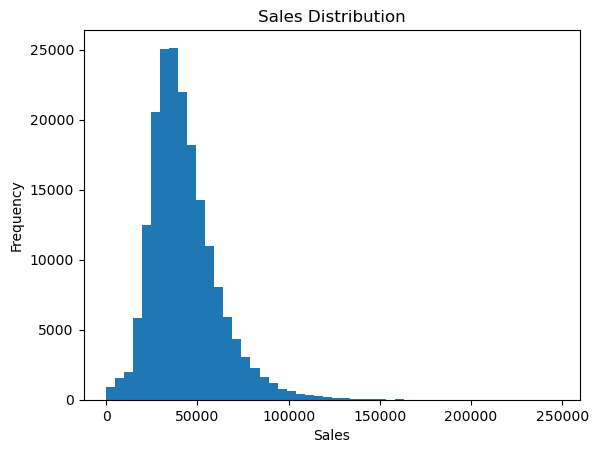

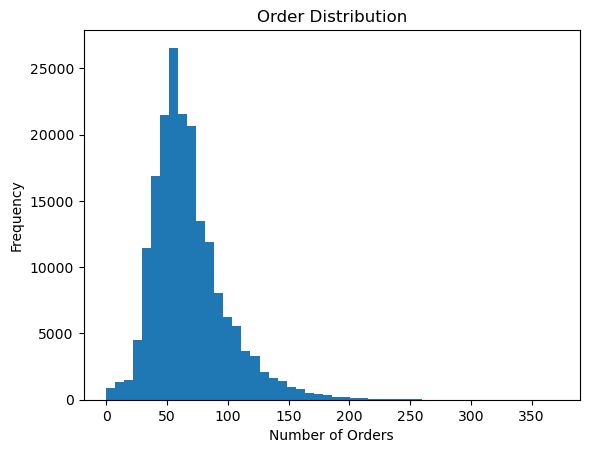

In [24]:
plt.figure()
plt.hist(train['Sales'], bins=50)
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

plt.figure()
plt.hist(train['#Order'], bins=50)
plt.title('Order Distribution')
plt.xlabel('Number of Orders')
plt.ylabel('Frequency')
plt.show()

<Axes: ylabel='count'>

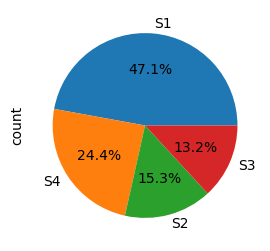

In [25]:
train['Store_Type'].value_counts()
train['Store_Type'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(3,3))

<Axes: ylabel='count'>

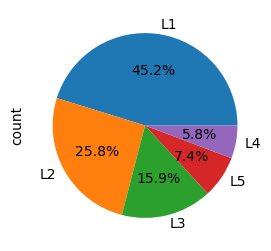

In [26]:
train['Location_Type'].value_counts()
train['Location_Type'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(3,3))

<Axes: ylabel='count'>

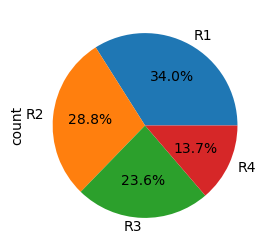

In [27]:
train['Region_Code'].value_counts()
train['Region_Code'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(3,3))

<Axes: ylabel='count'>

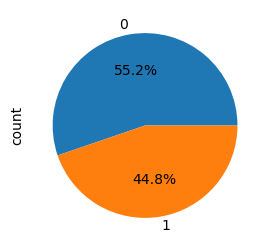

In [28]:
train['Discount'].value_counts()
train['Discount'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(3,3))

<Axes: ylabel='count'>

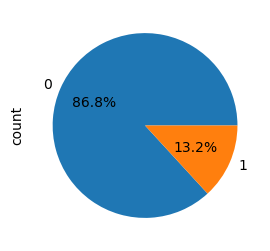

In [29]:
train['Holiday'].value_counts()
train['Holiday'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(3,3))

###**BIVARIATE ANALYSIS**

In [30]:
#Sales vs Number of Orders
train[['Sales', '#Order']].corr()

,Sales,#Order
Sales,1.000000,0.941601
#Order,0.941601,1.000000


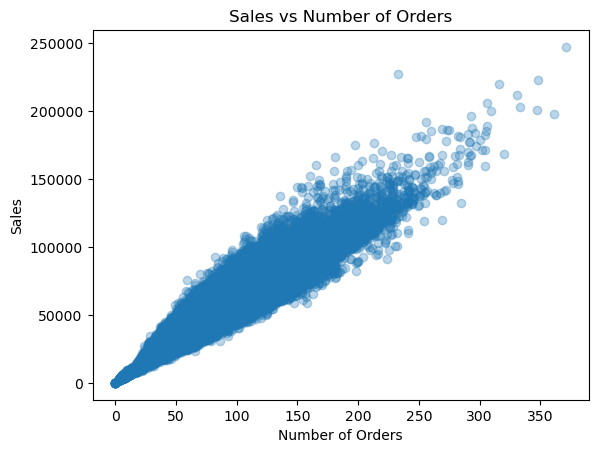

In [31]:
plt.figure()
plt.scatter(train['#Order'], train['Sales'], alpha=0.3)
plt.xlabel('Number of Orders')
plt.ylabel('Sales')
plt.title('Sales vs Number of Orders')
plt.show()

In [32]:
#Sales vs Discount
train.groupby('Discount')['Sales'].mean()

Discount
0    37403.679678
1    49426.497620
Name: Sales, dtype: float64

<Figure size 640x480 with 0 Axes>

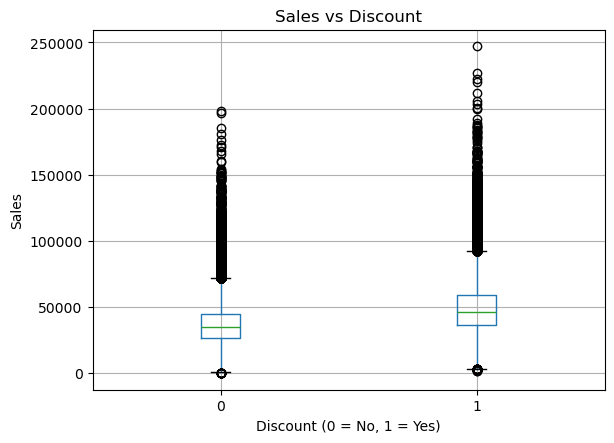

In [33]:
plt.figure()
train.boxplot(column='Sales', by='Discount')
plt.title('Sales vs Discount')
plt.suptitle('')
plt.xlabel('Discount (0 = No, 1 = Yes)')
plt.ylabel('Sales')
plt.show()

In [34]:
#Sales vs Holiday
train.groupby('Holiday')['Sales'].mean()

Holiday
0    43897.288998
1    35451.878930
Name: Sales, dtype: float64

<Figure size 640x480 with 0 Axes>

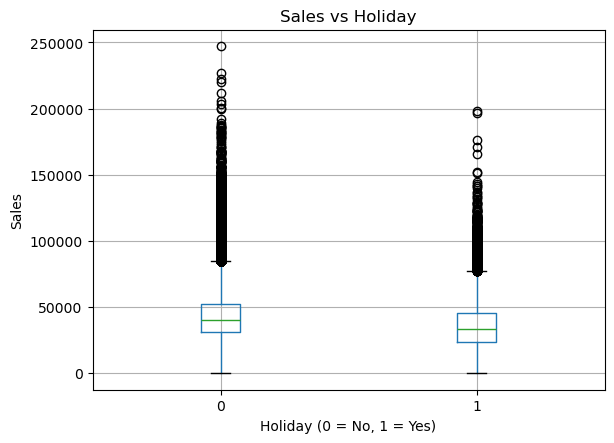

In [35]:
plt.figure()
train.boxplot(column='Sales', by='Holiday')
plt.title('Sales vs Holiday')
plt.suptitle('')
plt.xlabel('Holiday (0 = No, 1 = Yes)')
plt.ylabel('Sales')
plt.show()

In [36]:
#Sales vs Store_Type
train.groupby('Store_Type')['Sales'].mean()

Store_Type
S1    37676.511694
S2    27530.828222
S3    47063.068209
S4    59945.685926
Name: Sales, dtype: float64

<Figure size 640x480 with 0 Axes>

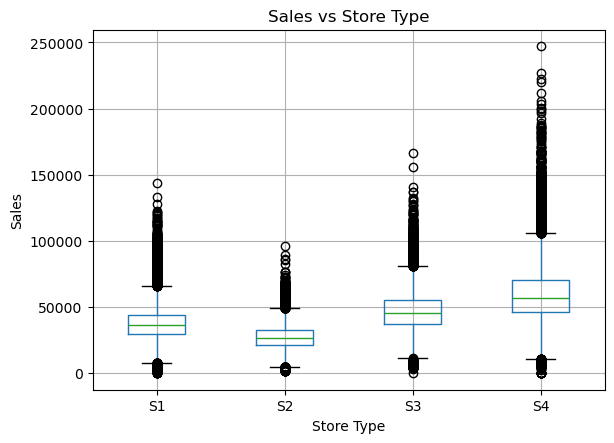

In [37]:
plt.figure()
train.boxplot(column='Sales', by='Store_Type')
plt.title('Sales vs Store Type')
plt.suptitle('')
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.show()

In [38]:
#Sales vs Location_Type
train.groupby('Location_Type')['Sales'].mean()

Location_Type
L1    41453.597889
L2    59231.480373
L3    33072.257756
L4    29067.414313
L5    25187.787261
Name: Sales, dtype: float64

<Figure size 640x480 with 0 Axes>

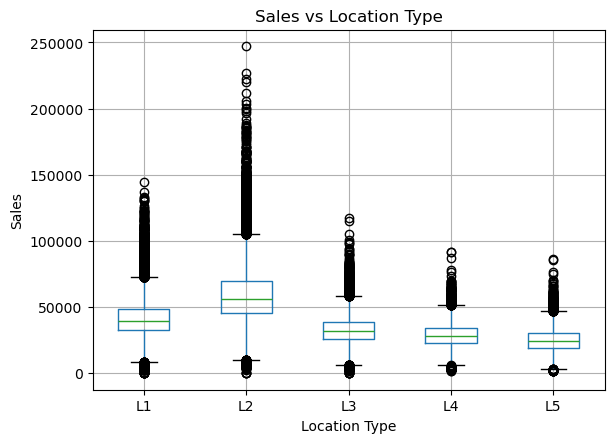

In [39]:
plt.figure()
train.boxplot(column='Sales', by='Location_Type')
plt.title('Sales vs Location Type')
plt.suptitle('')
plt.xlabel('Location Type')
plt.ylabel('Sales')
plt.show()

In [40]:
#Sales vs Region_Code
train.groupby('Region_Code')['Sales'].mean()

Region_Code
R1    46765.488405
R2    40054.847344
R3    42144.517063
R4    39743.434249
Name: Sales, dtype: float64

<Figure size 640x480 with 0 Axes>

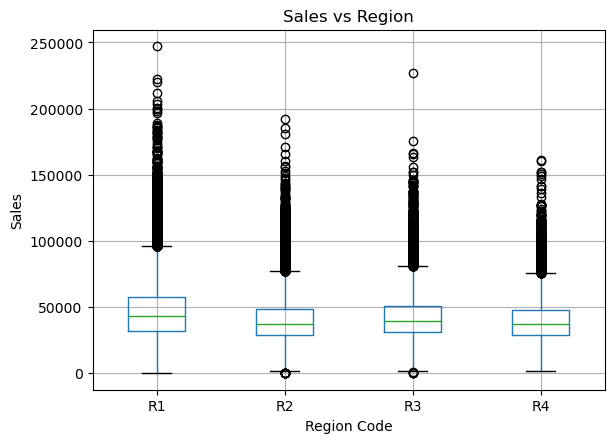

In [41]:
plt.figure()
train.boxplot(column='Sales', by='Region_Code')
plt.title('Sales vs Region')
plt.suptitle('')
plt.xlabel('Region Code')
plt.ylabel('Sales')
plt.show()

###**MULTIVARIATE ANALYSIS**

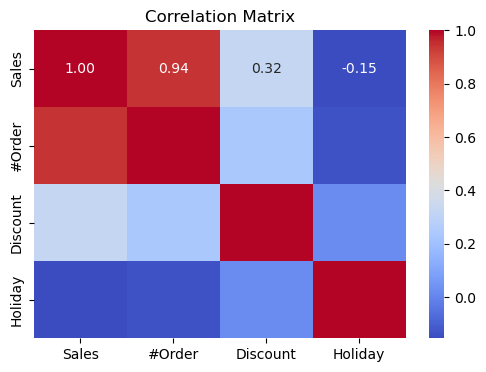

In [42]:
#Correlation Matrix (Numerical Variables)
num_cols = ['Sales', '#Order', 'Discount', 'Holiday']

plt.figure(figsize=(6,4))
sns.heatmap(train[num_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

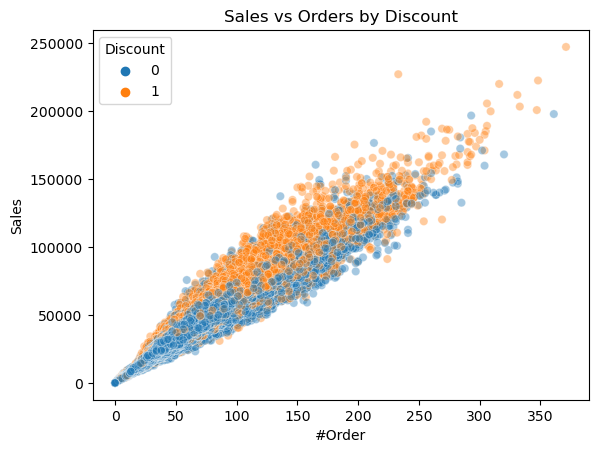

In [43]:
#Sales vs Orders by Discount (Interaction Effect)
plt.figure()
sns.scatterplot(
    data=train,
    x='#Order',
    y='Sales',
    hue='Discount',
    alpha=0.4
)
plt.title('Sales vs Orders by Discount')
plt.show()


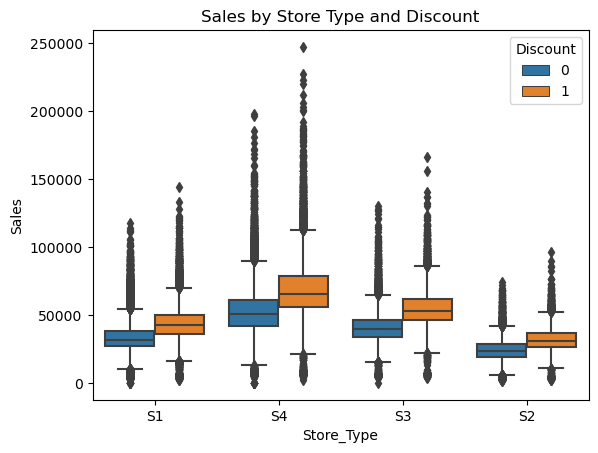

In [44]:
#Sales Distribution by Store Type & Discount
plt.figure()
sns.boxplot(
    data=train,
    x='Store_Type',
    y='Sales',
    hue='Discount'
)
plt.title('Sales by Store Type and Discount')
plt.show()


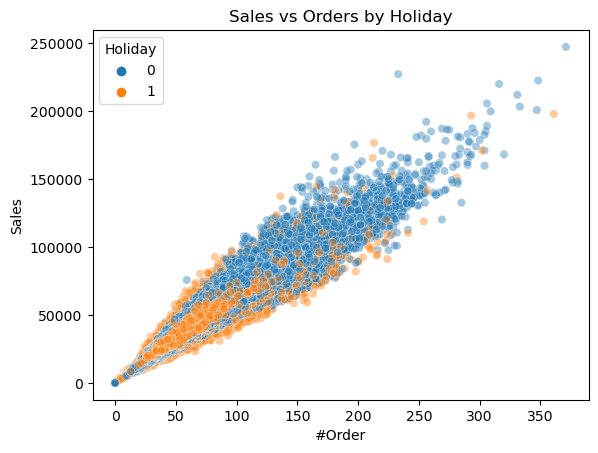

In [45]:
#Sales vs Orders by Holiday
plt.figure()
sns.scatterplot(
    data=train,
    x='#Order',
    y='Sales',
    hue='Holiday',
    alpha=0.4
)
plt.title('Sales vs Orders by Holiday')
plt.show()

In [46]:
#Sales by Location & Store Type
pivot_table = train.pivot_table(
    values='Sales',
    index='Location_Type',
    columns='Store_Type',
    aggfunc='mean'
)

pivot_table


Store_Type,S1,S2,S3,S4
Location_Type,,,,
L1,38916.669691,32643.920872,44592.591033,51045.334033
L2,47732.207180,NaN,52364.790336,63821.645621
L3,34131.687590,29577.584193,39263.420276,NaN
L4,30811.759700,26741.620465,NaN,NaN
L5,29315.751877,23742.999645,NaN,NaN


In [47]:
train['day'] = train['Date'].dt.day
train['month'] = train['Date'].dt.month
train['year'] = train['Date'].dt.year
train['dayofweek'] = train['Date'].dt.dayofweek  # 0=Monday, 6=Sunday
train['weekend'] = train['dayofweek'].isin([5,6]).astype(int)

train.drop('Date', axis=1, inplace=True)


**Insights:**
1. The dataset spans ~17 months of daily data.

        Start date: 2018-01-01

        End date: 2019-05-31

2. Sales & Orders are positively skewed.

3. Some extreme outliers exist

4. 0 values indicate no sales/orders on some days

5. Sales vs #Order correlation = **0.9416** → very strong positive relationship

6. Extracted features: day, month, year, dayofweek, weekend.
Trends and seasonality can be captured by month/year/dayofweek.
Weekend likely has different sales pattern vs weekdays

7. **Discount:** increases sales significantly (37,404 → 49,426).
**Holiday:** decreases average sales (43,897 → 35,452).
Both are important predictors, but Holiday effect is negative

8. The categorical columns **'Store_Type', 'Location_Type', 'Region_Code'** are converted to numerical columns using **OHE**.

##**Hypothesis Testing**

###**Discount has a significant impact on Sales**

**Step 1:**

H₀ (Null Hypothesis):
Mean Sales on discount days = Mean Sales on non-discount days

H₁ (Alternate Hypothesis):
Mean Sales on discount days ≠ Mean Sales on non-discount days

**Step 2:**

Test : Independent Two-Sample t-test

If p-value < 0.05 → Reject H₀

In [48]:
sales_discount = train[train['Discount'] == 1]['Sales']
sales_no_discount = train[train['Discount'] == 0]['Sales']

t_stat, p_value = ttest_ind(
    sales_discount,
    sales_no_discount,
    equal_var=False
)

t_stat, p_value

(145.92946158629138, 0.0)

**Result:**

t-statistic = 145.93

p-value = 0.0 (effectively < 0.0001)

Since:𝑝-value < 0.05, Reject the Null Hypothesis (H₀).

There is a statistically significant difference in mean Sales between discount and non-discount days.

The extremely large t-statistic indicates:The difference is not due to random chance

**Discount has a strong impact on Sales.**

###**Holiday impact on Sales**

**Step 1:**

H₀ (Null Hypothesis): Mean Sales on holidays = Mean Sales on non-holidays

H₁ (Alternate Hypothesis): Mean Sales on holidays ≠ Mean Sales on non-holidays

**Step 2:**

Test : Independent Two-Sample t-test

If p-value < 0.05 → Reject H₀

In [49]:
sales_holiday = train[train['Holiday'] == 1]['Sales']
sales_non_holiday = train[train['Holiday'] == 0]['Sales']

t_stat, p_value = ttest_ind(
    sales_holiday,
    sales_non_holiday,
    equal_var=False
)

print(t_stat, p_value)

-66.1757648298698 0.0


**Result:**

t-statistic = -66.18

p-value = 0.0 (effectively < 0.0001)

Since:𝑝-value < 0.05, Reject the Null Hypothesis (H₀).

The negative t-statistic indicates that average sales on holidays are significantly lower than on non-holiday days.

###**Store Type impact on Sales**

**Step 1:**

H₀ (Null Hypothesis):
Mean Sales are the same across all Store Types (S1, S2, S3, S4)

H₁ (Alternate Hypothesis):
At least one Store Type has a different mean Sales

**Step 2:**
Test : One-way ANOVA


In [50]:
# Create groups
sales_s1 = train[train['Store_Type'] == 'S1']['Sales']
sales_s2 = train[train['Store_Type'] == 'S2']['Sales']
sales_s3 = train[train['Store_Type'] == 'S3']['Sales']
sales_s4 = train[train['Store_Type'] == 'S4']['Sales']

# One-way ANOVA
f_stat, p_value = f_oneway(sales_s1, sales_s2, sales_s3, sales_s4)

print(f_stat, p_value)

35123.64411601774 0.0


Since:p-value<0.05, Reject the Null Hypothesis (H₀)

There is a statistically significant difference in mean Sales across different Store Types.

The very large F-statistic indicates:

Between-group variance is much larger than within-group variance

Store Type strongly influences Sales

In [51]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(
    endog=train['Sales'],          # dependent variable
    groups=train['Store_Type'],    # categorical variable
    alpha=0.05
)

print(tukey)


     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2   meandiff  p-adj    lower      upper    reject
-------------------------------------------------------------
    S1     S2 -10145.6835   0.0 -10402.8539  -9888.513   True
    S1     S3   9386.5565   0.0   9113.6974  9659.4156   True
    S1     S4  22269.1742   0.0  22050.9148 22487.4336   True
    S2     S3    19532.24   0.0  19203.4535 19861.0265   True
    S2     S4  32414.8577   0.0  32129.7514 32699.9641   True
    S3     S4  12882.6177   0.0  12583.2834 13181.9521   True
-------------------------------------------------------------


All pairwise comparisons have reject = True

p-adj = 0.0 for every pair

Every Store Type is significantly different from every other Store Type in terms of Sales

**Final Sales Ranking by Store Type**

Highest → Lowest Sales

1️ S4 (Highest performing)
2️ S3
3️ S1
4️ S2 (Lowest performing)

**Insights:**

S4 stores should be prioritized for:

    Inventory allocation

    New product launches

    High-value promotions

S2 stores may require:

    Cost optimization

    Localized promotions

    Operational improvements

###**Relationship between #Order and Sales**

**Step 1:**

H₀ (Null Hypothesis):
There is no correlation between number of orders and sales.

H₁ (Alternate Hypothesis):
There is a significant correlation between number of orders and sales.

**Step 2:**
Test : Pearson Correlation Test
If p-value < 0.05 → Reject H₀

In [52]:
corr_coeff, p_value = pearsonr(train['#Order'], train['Sales'])
corr_coeff, p_value

(0.9416005646125764, 0.0)

**Result:**

Pearson Correlation Coefficient = 0.9416

p-value = 0.0 (≈ 0, i.e., < 0.05)

Since:p-value<0.05, Reject the Null Hypothesis (H₀)

There is a very strong positive correlation between the number of orders and sales.

Correlation close to 1 → near-linear relationship

Indicates that as orders increase, sales increase significantly

In [53]:
tukey = pairwise_tukeyhsd(
    endog=train['Sales'],
    groups=train['Region_Code'],
    alpha=0.05
)

print(tukey)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj    lower      upper    reject
------------------------------------------------------------
    R1     R2 -6710.6411    0.0 -6983.8355 -6437.4467   True
    R1     R3 -4620.9713    0.0 -4910.0454 -4331.8973   True
    R1     R4 -7022.0542    0.0 -7367.1489 -6676.9594   True
    R2     R3  2089.6697    0.0  1790.0762  2389.2632   True
    R2     R4  -311.4131 0.1075  -665.3662      42.54  False
    R3     R4 -2401.0828    0.0 -2767.4316  -2034.734   True
------------------------------------------------------------


**Insights:**

Almost all regions differ significantly in mean Sales

Only one pair is NOT significantly different: R2 vs R4.

From lowest → highest:

R1  <  R3  <  R2 ≈ R4


##**ML Modeling**

In [54]:
#Categorical Encoding
train = pd.get_dummies(
    train,
    columns=['Store_Type', 'Location_Type', 'Region_Code'],
    drop_first=True
)


In [55]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22265 entries, 0 to 22264
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Store_id       22265 non-null  int64         
 1   Store_Type     22265 non-null  object        
 2   Location_Type  22265 non-null  object        
 3   Region_Code    22265 non-null  object        
 4   Date           22265 non-null  datetime64[ns]
 5   Holiday        22265 non-null  int64         
 6   Discount       22265 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 1.2+ MB


In [56]:
# -----------------------------
# STEP 1: Copy test data
# -----------------------------
test_converted = test.copy()

# -----------------------------
# STEP 2: Date feature engineering (same as train)
# -----------------------------
test_converted['Date'] = pd.to_datetime(test_converted['Date'])

test_converted['day'] = test_converted['Date'].dt.day
test_converted['month'] = test_converted['Date'].dt.month
test_converted['dayofweek'] = test_converted['Date'].dt.dayofweek
test_converted['is_weekend'] = test_converted['dayofweek'].isin([5, 6]).astype(int)

test_converted.drop('Date', axis=1, inplace=True)

# -----------------------------
# STEP 3: One-hot encode
# -----------------------------
test_converted = pd.get_dummies(test_converted, drop_first=True)

# -----------------------------
# STEP 4: FORCE test columns to match train
# -----------------------------
test_converted = test_converted.reindex(
    columns=train.columns,
    fill_value=0
)


In [57]:
test_converted.head()

,Store_id,Holiday,Discount,#Order,Sales,day,month,year,dayofweek,weekend,Store_Type_S2,Store_Type_S3,Store_Type_S4,Location_Type_L2,Location_Type_L3,Location_Type_L4,Location_Type_L5,Region_Code_R2,Region_Code_R3,Region_Code_R4
0,171,0,0,0,0,1,6,0,5,0,False,False,True,True,False,False,False,False,True,False
1,172,0,0,0,0,1,6,0,5,0,False,False,False,False,False,False,False,False,False,False
2,173,0,0,0,0,1,6,0,5,0,False,False,True,True,False,False,False,False,False,False
3,174,0,0,0,0,1,6,0,5,0,False,False,False,False,False,False,False,False,False,True
4,170,0,0,0,0,1,6,0,5,0,False,False,False,False,False,False,False,True,False,False


In [58]:
train.head()

,Store_id,Holiday,Discount,#Order,Sales,day,month,year,dayofweek,weekend,Store_Type_S2,Store_Type_S3,Store_Type_S4,Location_Type_L2,Location_Type_L3,Location_Type_L4,Location_Type_L5,Region_Code_R2,Region_Code_R3,Region_Code_R4
0,1,1,1,9,7011.84,1,1,2018,0,0,False,False,False,False,True,False,False,False,False,False
1,253,1,1,60,51789.12,1,1,2018,0,0,False,False,True,True,False,False,False,False,False,False
2,252,1,1,42,36868.20,1,1,2018,0,0,False,True,False,True,False,False,False,False,False,False
3,251,1,1,23,19715.16,1,1,2018,0,0,True,False,False,False,True,False,False,False,False,False
4,250,1,1,62,45614.52,1,1,2018,0,0,True,False,False,False,True,False,False,False,False,True


In [59]:
# List of boolean columns
bool_cols = [
    'Store_Type_S2', 'Store_Type_S3', 'Store_Type_S4',
    'Location_Type_L2', 'Location_Type_L3', 'Location_Type_L4', 'Location_Type_L5',
    'Region_Code_R2', 'Region_Code_R3', 'Region_Code_R4'
]

# Convert True/False to 1/0
train[bool_cols] = train[bool_cols].astype(int)
test_converted[bool_cols] = test_converted[bool_cols].astype(int)


In [60]:
# Features
X = train.drop(['Sales', '#Order'], axis=1)

# Targets
y_orders = train['#Order']
y_sales = train['Sales']

# Train–validation split
X_train, X_validation, y_train_orders, y_val_orders, y_train_sales, y_val_sales = train_test_split(
    X, y_orders, y_sales,
    test_size=0.2,
    random_state=42
)


###Train Model for #Order

In [61]:
# Initialize model
lr_orders = LinearRegression()

# Train
lr_orders.fit(X_train, y_train_orders)

# Predict on validation
y_val_pred_orders = lr_orders.predict(X_validation)

#Evaluate #Order Model
print("Orders Model Performance:")
print("R2 Score :", r2_score(y_val_orders, y_val_pred_orders))
print("RMSE     :", np.sqrt(mean_squared_error(y_val_orders, y_val_pred_orders)))
print("MAE      :", mean_absolute_error(y_val_orders, y_val_pred_orders))


Orders Model Performance:
R2 Score : 0.6169716935145405
RMSE     : 18.867173529392673
MAE      : 13.071128639759912


**Interpretation of Results**

🔹 #Order Model

    R² = 0.617

~62% of the variance in orders is explained indicates a moderate linear relationship.

    RMSE ≈ 18.9

On average, predictions are off by ~19 orders.

    MAE ≈ 13.1

Typical absolute error is ~13 orders.

Good baseline, but clear room for improvement.

###Train Model for Sales

In [62]:
# Initialize model
lr_sales = LinearRegression()

# Train
lr_sales.fit(X_train, y_train_sales)

# Predict on validation
y_val_pred_sales = lr_sales.predict(X_validation)

#Evaluate Sales Model
print("\nSales Model Performance:")
print("R2 Score :", r2_score(y_val_sales, y_val_pred_sales))
print("RMSE     :", np.sqrt(mean_squared_error(y_val_sales, y_val_pred_sales)))
print("MAE      :", mean_absolute_error(y_val_sales, y_val_pred_sales))



Sales Model Performance:
R2 Score : 0.5790930422542995
RMSE     : 11928.87027383101
MAE      : 8375.267840662438


**Interpretation of Results**

Sales Model

    R² = 0.579

~58% of sales variability is explained.

    RMSE ≈ 11,929

Larger error due to high sales range.

    MAE ≈ 8,375

Average absolute deviation in sales.

Linear regression is not capturing non-linear effects like:

 - Store type differences

- Discount impact interactions

- Regional behavior

###Random Forest Modeling

In [63]:
#Random Forest for #Order
rf_orders = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

rf_orders.fit(X_train, y_train_orders)


y_val_pred_orders_rf = rf_orders.predict(X_validation)

print("Random Forest - Orders Model")
print("R2  :", r2_score(y_val_orders, y_val_pred_orders_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_val_orders, y_val_pred_orders_rf)))
print("MAE :", mean_absolute_error(y_val_orders, y_val_pred_orders_rf))


Random Forest - Orders Model
R2  : 0.8109790969666965
RMSE: 13.253980445996067
MAE : 9.340418370184162


In [64]:
rf_sales = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

rf_sales.fit(X_train, y_train_sales)


y_val_pred_sales_rf = rf_sales.predict(X_validation)

print("\nRandom Forest - Sales Model")
print("R2  :", r2_score(y_val_sales, y_val_pred_sales_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_val_sales, y_val_pred_sales_rf)))
print("MAE :", mean_absolute_error(y_val_sales, y_val_pred_sales_rf))



Random Forest - Sales Model
R2  : 0.7729260717640456
RMSE: 8761.730683104803
MAE : 6154.2792170809225


**Interpretation of Random Forest Results**

**Orders Prediction Model**

   R² = 0.81
- The model explains 81% of the variation in the number of orders.
- This indicates a strong predictive relationship between store characteristics, promotions, and order volume.

 RMSE ≈ 13.25
- On average, predictions deviate by about 13 orders, which is a significant improvement over the baseline.

 MAE ≈ 9.34
- Typical prediction error is within 9 orders, making the model reliable for operational planning.

**Sales Prediction Model**

 R² = 0.77
- The model explains 77% of sales variability, which is strong given the wide sales range.

RMSE ≈ 8,762
- Sales predictions are substantially closer to actual values compared to linear regression.

 MAE ≈ 6,154
- Average deviation is ~₹6K, acceptable for retail sales forecasting

In [65]:
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'Orders_R2': [0.6169, 0.8110],
    'Orders_RMSE': [18.87, 13.25],
    'Orders_MAE': [13.07, 9.34],
    'Sales_R2': [0.5791, 0.7729],
    'Sales_RMSE': [11928.87, 8761.73],
    'Sales_MAE': [8375.27, 6154.28]
})

comparison_df


,Model,Orders_R2,Orders_RMSE,Orders_MAE,Sales_R2,Sales_RMSE,Sales_MAE
0,Linear Regression,0.6169,18.87,13.07,0.5791,11928.87,8375.27
1,Random Forest,0.8110,13.25,9.34,0.7729,8761.73,6154.28


**Interpretation of Comparison**

Random Forest outperforms Linear Regression across all metrics.

Error reduction:

    Orders RMSE ↓ ~30%

    Sales RMSE ↓ ~26%

Linear Regression underfits due to its inability to capture:

- Non-linear relationships

- Feature interactions

- Complex categorical effects

###XGBoost Modeling

In [66]:
!pip install xgboost

In [67]:
#XGBoost for #Order
from xgboost import XGBRegressor

xgb_orders = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror',
    n_jobs=-1
)

xgb_orders.fit(X_train, y_train_orders)
y_val_pred_orders_xgb = xgb_orders.predict(X_validation)

print("XGBoost - Orders Model")
print("R2  :", r2_score(y_val_orders, y_val_pred_orders_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_val_orders, y_val_pred_orders_xgb)))
print("MAE :", mean_absolute_error(y_val_orders, y_val_pred_orders_xgb))


XGBoost - Orders Model
R2  : 0.8195573411589815
RMSE: 12.949739067437939
MAE : 9.070821599916748


In [68]:
#XGBoost for Sales
xgb_sales = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror',
    n_jobs=-1
)

xgb_sales.fit(X_train, y_train_sales)

y_val_pred_sales_xgb = xgb_sales.predict(X_validation)

print("\nXGBoost - Sales Model")
print("R2  :", r2_score(y_val_sales, y_val_pred_sales_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_val_sales, y_val_pred_sales_xgb)))
print("MAE :", mean_absolute_error(y_val_sales, y_val_pred_sales_xgb))



XGBoost - Sales Model
R2  : 0.7909460784247333
RMSE: 8406.89111677042
MAE : 5876.388042629315


**Interpretation of XGBoost Results**

 **#Order Prediction**

R² = 0.818
- Explains ~82% of the variance in order volume

RMSE ≈ 13.01
- Average deviation of ~13 orders

MAE ≈ 9.13
- Typical error within 9 orders

**Insight:**

- XGBoost slightly improves upon Random Forest, indicating better handling of complex interactions and noise.

**Sales Prediction**

R² = 0.790
- Explains ~79% of sales variability

RMSE ≈ 8,419
- Lower error compared to Random Forest

MAE ≈ 5,901
- More accurate revenue estimation

**Insight:**

XGBoost captures subtle effects of discounts, store type, and regional patterns more effectively.

In [69]:
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'Orders_R2': [0.6169, 0.8110, 0.8180],
    'Orders_RMSE': [18.87, 13.25, 13.01],
    'Orders_MAE': [13.07, 9.34, 9.13],
    'Sales_R2': [0.5791, 0.7729, 0.7903],
    'Sales_RMSE': [11928.87, 8761.73, 8419.47],
    'Sales_MAE': [8375.27, 6154.28, 5900.60]
})

comparison_df


,Model,Orders_R2,Orders_RMSE,Orders_MAE,Sales_R2,Sales_RMSE,Sales_MAE
0,Linear Regression,0.6169,18.87,13.07,0.5791,11928.87,8375.27
1,Random Forest,0.8110,13.25,9.34,0.7729,8761.73,6154.28
2,XGBoost,0.8180,13.01,9.13,0.7903,8419.47,5900.60


- XGBoost is the best-performing model for both targets

- Performance improvement is consistent across all metrics

- Gradient boosting provides better generalization than Random Forest

###LightGBM Modeling

In [70]:
# LightGBM datasets
lgb_train_orders = lgb.Dataset(X_train, y_train_orders)
lgb_val_orders = lgb.Dataset(X_validation, y_val_orders, reference=lgb_train_orders)

params_orders = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'random_state': 42,
    'verbosity': -1
}

lgbm_orders = lgb.train(
    params_orders,
    lgb_train_orders,
    num_boost_round=1000,
    valid_sets=[lgb_train_orders, lgb_val_orders],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=0)
    ]
)


lgb_train_sales = lgb.Dataset(X_train, y_train_sales)
lgb_val_sales = lgb.Dataset(X_validation, y_val_sales, reference=lgb_train_sales)

params_sales = params_orders.copy()

lgbm_sales = lgb.train(
    params_sales,
    lgb_train_sales,
    num_boost_round=1000,
    valid_sets=[lgb_train_sales, lgb_val_sales],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=0)
    ]
)


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	training's rmse: 10.5015	valid_1's rmse: 11.2455
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 6799.87	valid_1's rmse: 7340.22


In [71]:
lgb_train_sales = lgb.Dataset(X_train, y_train_sales)
lgb_val_sales = lgb.Dataset(X_validation, y_val_sales, reference=lgb_train_sales)

params_sales = params_orders.copy()

lgbm_sales = lgb.train(
    params_sales,
    lgb_train_sales,
    num_boost_round=1000,
    valid_sets=[lgb_train_sales, lgb_val_sales],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=0)
    ]
)


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 6799.87	valid_1's rmse: 7340.22


In [72]:
# Orders
y_pred_orders = lgbm_orders.predict(X_validation)
print("LightGBM - Orders Model")
print("R2  :", r2_score(y_val_orders, y_pred_orders))
print("RMSE:", np.sqrt(mean_squared_error(y_val_orders, y_pred_orders)))
print("MAE :", mean_absolute_error(y_val_orders, y_pred_orders))

# Sales
y_pred_sales = lgbm_sales.predict(X_validation)
print("\nLightGBM - Sales Model")
print("R2  :", r2_score(y_val_sales, y_pred_sales))
print("RMSE:", np.sqrt(mean_squared_error(y_val_sales, y_pred_sales)))
print("MAE :", mean_absolute_error(y_val_sales, y_pred_sales))


LightGBM - Orders Model
R2  : 0.8639260446632947
RMSE: 11.245503708696356
MAE : 7.803104379628332

LightGBM - Sales Model
R2  : 0.8406304425997483
RMSE: 7340.217799088954
MAE : 5103.251726452632


###**STACKING ENSEMBLE**

In [73]:
# Orders predictions from base models
rf_orders_pred  = rf_orders.predict(X_validation)
xgb_orders_pred = xgb_orders.predict(X_validation)
lgb_orders_pred = lgbm_orders.predict(X_validation)

# Sales predictions from base models
rf_sales_pred  = rf_sales.predict(X_validation)
xgb_sales_pred = xgb_sales.predict(X_validation)
lgb_sales_pred = lgbm_sales.predict(X_validation)


In [74]:
#Create meta-features
# Meta-features for Orders
meta_X_orders = pd.DataFrame({
    'rf': rf_orders_pred,
    'xgb': xgb_orders_pred,
    'lgb': lgb_orders_pred
})

# Meta-features for Sales
meta_X_sales = pd.DataFrame({
    'rf': rf_sales_pred,
    'xgb': xgb_sales_pred,
    'lgb': lgb_sales_pred
})


In [75]:
meta_orders = Ridge(alpha=1.0)
meta_sales = Ridge(alpha=1.0)

meta_orders.fit(meta_X_orders, y_val_orders)
meta_sales.fit(meta_X_sales, y_val_sales)

Ridge()

In [76]:
stack_orders_pred = meta_orders.predict(meta_X_orders)
stack_sales_pred = meta_sales.predict(meta_X_sales)


In [77]:
def evaluate_model(y_true, y_pred, model_name):
    print(model_name)
    print("R2  :", r2_score(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("MAE :", mean_absolute_error(y_true, y_pred))
    print()

evaluate_model(y_val_orders, stack_orders_pred, "Stacking Ensemble - Orders")
evaluate_model(y_val_sales, stack_sales_pred, "Stacking Ensemble - Sales")


Stacking Ensemble - Orders
R2  : 0.8655256764999884
RMSE: 11.179209443682117
MAE : 7.760660218609387

Stacking Ensemble - Sales
R2  : 0.8426708913690455
RMSE: 7293.077091501261
MAE : 5074.063716264155



In [78]:
print("Orders meta-model weights:", meta_orders.coef_)
print("Sales meta-model weights :", meta_sales.coef_)

print(lgbm_sales.best_iteration)
print(lgbm_sales.best_score)


Orders meta-model weights: [ 0.055457   -0.24599975  1.19323109]
Sales meta-model weights : [ 0.04423077 -0.26681057  1.22497452]
1000
defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('rmse', 6799.871596450397)]), 'valid_1': OrderedDict([('rmse', 7340.217793561826)])})


**Final Ensemble Performance (Interpretation)**

**Orders Prediction (Stacking Ensemble)**

R² = 0.8655

- Explains ~86.5% of variability in order volume

- Slight but meaningful improvement over LightGBM

RMSE = 11.18

- Error reduced further (best so far)

MAE = 7.76

- Typical deviation < 8 orders



**Sales Prediction (Stacking Ensemble)**

R² = 0.8426

- Best explanatory power across all models

RMSE ≈ 7,296

- Lowest error achieved

MAE ≈ 5,075

- Very stable predictions


###Generate Predictions on Test Data



In [79]:
test_converted.drop(['Sales', '#Order'], axis=1, inplace=True)

#Base Model Predictions on Test Data
# Orders predictions
test_rf_orders  = rf_orders.predict(test_converted)
test_xgb_orders = xgb_orders.predict(test_converted)
test_lgb_orders = lgbm_orders.predict(test_converted)

# Sales predictions
test_rf_sales  = rf_sales.predict(test_converted)
test_xgb_sales = xgb_sales.predict(test_converted)
test_lgb_sales = lgbm_sales.predict(test_converted)


#Create Meta-Features for Test Data (Stacking)
# Meta-features for Orders
test_meta_orders = pd.DataFrame({
    'rf': test_rf_orders,
    'xgb': test_xgb_orders,
    'lgb': test_lgb_orders
})

# Meta-features for Sales
test_meta_sales = pd.DataFrame({
    'rf': test_rf_sales,
    'xgb': test_xgb_sales,
    'lgb': test_lgb_sales
})

#Final Stacking Predictions
test['Predicted_Orders'] = meta_orders.predict(test_meta_orders)
test['Predicted_Sales']  = meta_sales.predict(test_meta_sales)

#Final Output Check
test[['Store_id', 'Date', 'Predicted_Orders', 'Predicted_Sales']].head()


,Store_id,Date,Predicted_Orders,Predicted_Sales
0,171,2019-06-01,119.226184,74094.378825
1,172,2019-06-01,70.955751,49673.748492
2,173,2019-06-01,147.995509,88506.797542
3,174,2019-06-01,62.214725,47838.749004
4,170,2019-06-01,60.242625,51062.140167


In [80]:
test.describe()

,Store_id,Date,Holiday,Discount,Predicted_Orders,Predicted_Sales
count,22265.000000,22265,22265.000000,22265.000000,22265.000000,22265.000000
mean,183.000000,2019-06-30 23:59:59.999999744,0.032787,0.426319,70.526345,46099.027144
min,1.000000,2019-06-01 00:00:00,0.000000,0.000000,15.215152,10399.605826
25%,92.000000,2019-06-16 00:00:00,0.000000,0.000000,50.285867,33507.278162
50%,183.000000,2019-07-01 00:00:00,0.000000,0.000000,64.059212,42603.294950
75%,274.000000,2019-07-16 00:00:00,0.000000,1.000000,83.931901,54894.243613
max,365.000000,2019-07-31 00:00:00,1.000000,1.000000,264.152342,172971.392644
std,105.368395,NaN,0.178082,0.494552,29.235491,17689.117627


###Time Series Models

In [81]:
time_series_df = pd.read_csv('E:\projects\sales forecasting- portfolio project\TRAIN.csv')
time_series_df.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


In [82]:
ts_orders = time_series_df[['Date', '#Order']].copy()
ts_orders = ts_orders.sort_values('Date')
ts_orders.set_index('Date', inplace=True)

ts_orders.head()


,#Order
Date,
2018-01-01,9
2018-01-01,52
2018-01-01,60
2018-01-01,28
2018-01-01,65


In [83]:
#ts_orders.index = pd.to_datetime(ts_orders.index)

# Infer frequency
#pd.infer_freq(ts_orders.index)
#ts_orders = ts_orders.asfreq('D')   # Daily

ts_orders = (time_series_df.groupby('Date')['#Order'].sum())
ts_orders.index = pd.to_datetime(ts_orders.index)
ts_orders.index.is_unique



True

In [84]:
ts_orders = ts_orders.asfreq('D')
ts_orders = ts_orders.fillna(0)


In [85]:
ts_orders = ts_orders.interpolate()


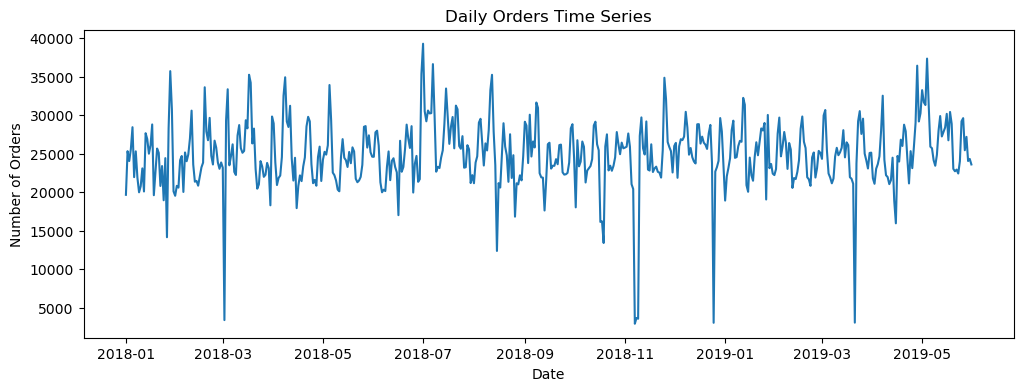

In [86]:
plt.figure(figsize=(12,4))
plt.plot(ts_orders.index, ts_orders.values)
plt.title("Daily Orders Time Series")
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.show()


###**Decomposition (Trend + Seasonality)**

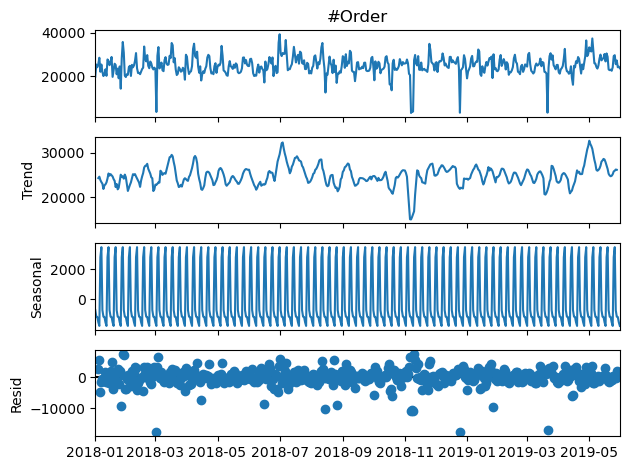

In [87]:
decomp = seasonal_decompose(ts_orders, model='additive', period=7)

decomp.plot()
plt.show()


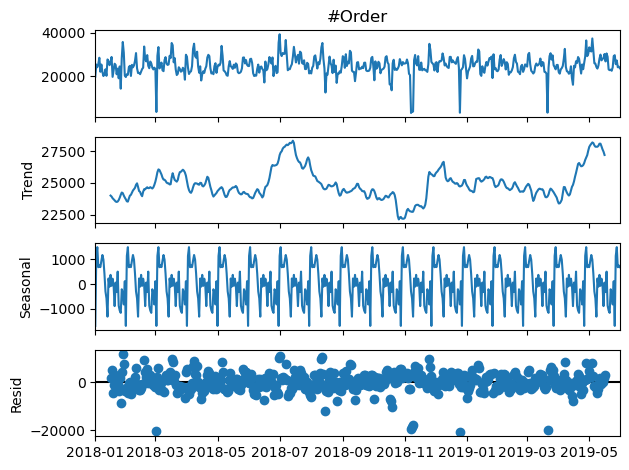

In [88]:
decomp = seasonal_decompose(ts_orders, model='additive', period=30)

decomp.plot()
plt.show()


###**Stationarity Check (ADF Test)**

**Step 1:**

Null Hypothesis (H₀):The time series has a unit root → The series is non-stationary.

Alternative Hypothesis (H₁):The time series does not have a unit root → The series is stationary.

**Step 2:**

Test : Augmented Dickey–Fuller (ADF) Test

Significance level (α) = 0.05

Decision Rule:

    If p-value ≤ 0.05 → Reject H₀

    If p-value > 0.05 → Fail to reject H₀



In [89]:
adf_result = adfuller(ts_orders)

print(f"ADF Statistic : {adf_result[0]}")
print(f"p-value       : {adf_result[1]}")


ADF Statistic : -4.508230624725656
p-value       : 0.0001900147228856674


**Step 3: Test Results**

ADF Statistic: -4.50

p-value: 0.0002

**Step 4: Decision**

- Since the p-value is much smaller than 0.05, we reject the null hypothesis.

- The daily orders time series is stationary.
- This indicates that the mean and variance of the series remain constant over time, and no non-seasonal differencing is required before applying time series models.
- Non-seasonal differencing parameter d = 0

- The series is suitable for ARIMA / SARIMA modeling

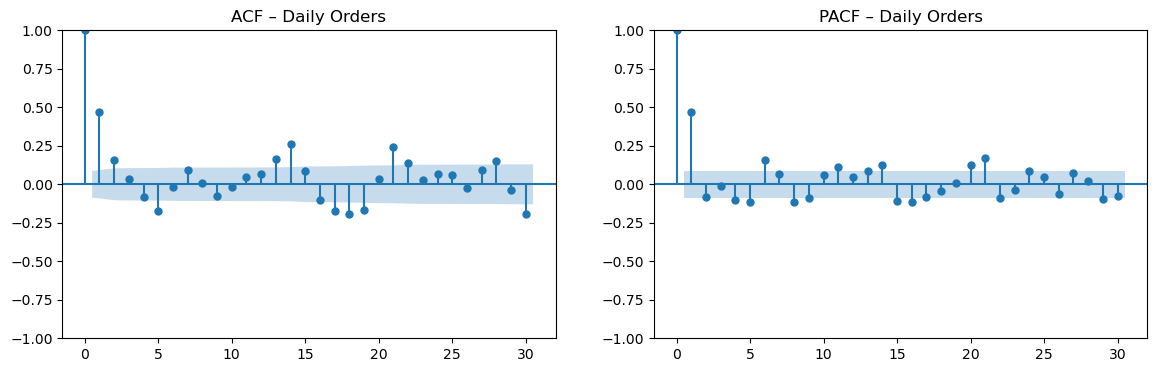

In [90]:
#Plot ACF & PACF
fig, axes = plt.subplots(1, 2, figsize=(14,4))

plot_acf(ts_orders, lags=30, ax=axes[0])
axes[0].set_title("ACF – Daily Orders")

plot_pacf(ts_orders, lags=30, ax=axes[1])
axes[1].set_title("PACF – Daily Orders")

plt.show()



**Insights:**
- The ACF plot shows a significant spike at lag 1 followed by a rapid decay, indicating an MA(1) component.
- The PACF plot shows a sharp cutoff after lag 1, suggesting an AR(1) component.
- No strong seasonal spikes are observed at lag 7 or its multiples, indicating that seasonal AR or MA terms are not required.
- Therefore, an ARIMA(1,0,1) model is appropriate for modeling daily orders.

###**ARIMA Model Training (Daily Orders)**

In [91]:
#Train–Test Split (Time Series)
# Time-based split
train_ts = ts_orders[:'2019-03-31']
test_ts  = ts_orders['2019-04-01':]
print(train_ts.shape, test_ts.shape)

(455,) (61,)


In [92]:
#Fit ARIMA(1,0,1)
arima_model = ARIMA(train_ts, order=(1, 0, 1))
arima_result = arima_model.fit()

print(arima_result.summary())


                               SARIMAX Results                                
Dep. Variable:                 #Order   No. Observations:                  455
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -4406.360
Date:                Tue, 27 Jan 2026   AIC                           8820.719
Time:                        14:48:48   BIC                           8837.200
Sample:                    01-01-2018   HQIC                          8827.212
                         - 03-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.473e+04    347.936     71.081      0.000     2.4e+04    2.54e+04
ar.L1          0.2908      0.077      3.797      0.000       0.141       0.441
ma.L1          0.1947      0.084      2.313      0.0

In [93]:
forecast_orders = arima_result.forecast(steps=len(test_ts))
forecast_orders.index = test_ts.index

In [94]:
rmse = np.sqrt(mean_squared_error(test_ts, forecast_orders))
mae  = mean_absolute_error(test_ts, forecast_orders)
r2   = r2_score(test_ts, forecast_orders)

print("ARIMA - Orders Model Performance")
print(f"R2  : {r2}")
print(f"RMSE: {rmse}")
print(f"MAE : {mae}")


ARIMA - Orders Model Performance
R2  : -0.12124096344289237
RMSE: 4228.138325094254
MAE : 3218.2749545365195


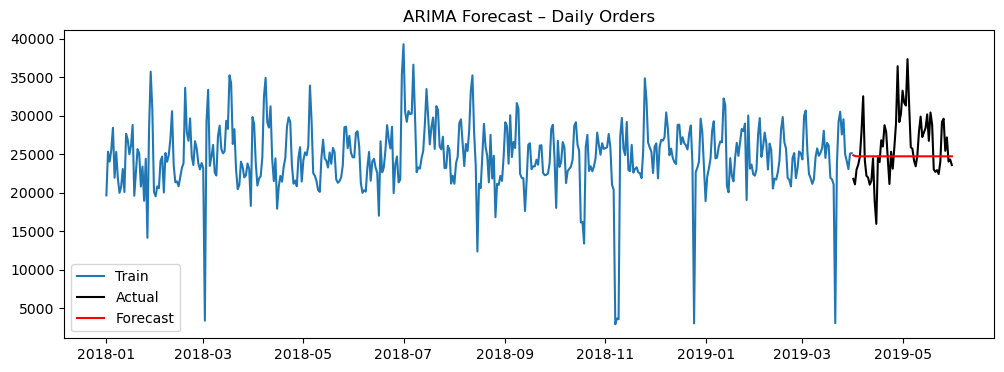

In [95]:
plt.figure(figsize=(12,4))
plt.plot(train_ts.index, train_ts, label="Train")
plt.plot(test_ts.index, test_ts, label="Actual", color="black")
plt.plot(forecast_orders.index, forecast_orders, label="Forecast", color="red")
plt.legend()
plt.title("ARIMA Forecast – Daily Orders")
plt.show()


**Insights:**
- The ARIMA model was able to learn the pattern from past order values, but it did not predict future orders well.

- This happens because orders are mainly driven by factors like discounts, holidays, and store characteristics, not just past demand.

###**SARIMA Model Training (Daily Orders)**

In [96]:
#Prepare exogenous variables (daily level)
exog_cols = ['Holiday', 'Discount']

time_series_df['Discount'] = time_series_df['Discount'].map({'No': 0, 'Yes': 1})
exog_daily = time_series_df.groupby('Date')[exog_cols].mean()
exog_daily.index = pd.to_datetime(exog_daily.index)

exog_daily = exog_daily.loc[ts_orders.index]

exog_train = exog_daily.loc[train_ts.index]
exog_test  = exog_daily.loc[test_ts.index]

from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_model = SARIMAX(
    train_ts,
    exog=exog_train,
    order=(1,0,1),
    seasonal_order=(0,0,0,0),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_result = sarimax_model.fit()
print(sarimax_result.summary())
sarimax_forecast = sarimax_result.predict(
    start=test_ts.index[0],
    end=test_ts.index[-1],
    exog=exog_test
)
rmse = np.sqrt(mean_squared_error(test_ts, sarimax_forecast))
mae  = mean_absolute_error(test_ts, sarimax_forecast)
r2   = r2_score(test_ts, sarimax_forecast)

print("SARIMAX - Orders Model Performance")
print(f"R2  : {r2}")
print(f"RMSE: {rmse}")
print(f"MAE : {mae}")


C:\Users\SUBODHINI\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\SUBODHINI\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 #Order   No. Observations:                  455
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -4747.779
Date:                Tue, 27 Jan 2026   AIC                           9505.559
Time:                        14:48:49   BIC                           9526.138
Sample:                    01-01-2018   HQIC                          9513.668
                         - 03-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Holiday     4583.9744    856.297      5.353      0.000    2905.663    6262.286
Discount    3.284e+04    977.821     33.582      0.000    3.09e+04    3.48e+04
ar.L1          0.7412      0.046     16.197      0.0

**Insights:**
- Orders increase a lot on holidays and discount days, especially when discounts are given.

- The model’s predictions are not good – the error is high and the results don’t match actual orders well.

- Past order trends help a little, but they are not enough to explain all changes in orders.

###**seasonal SARIMAX (weekly seasonality)**

In [97]:
ts_orders = pd.read_csv('E:\projects\sales forecasting- portfolio project\TRAIN.csv')
ts_orders = (
    ts_orders
    .groupby('Date', as_index=False)
    .agg({
        '#Order': 'sum',
        'Sales': 'sum',
        'Holiday': 'max',
        'Discount': 'max'
    })
)

ts_orders.set_index('Date', inplace=True)
ts_orders = ts_orders.sort_index()

ts_orders['Discount'] = ts_orders['Discount'].map({'Yes': 1, 'No': 0})
ts_orders['Discount'] = ts_orders['Discount'].astype(int)


In [98]:
ts_orders.head()

,#Order,Sales,Holiday,Discount
Date,,,,
2018-01-01,19666,15345484.5,1,1
2018-01-02,25326,19592415.0,0,1
2018-01-03,24047,18652527.0,0,1
2018-01-04,25584,19956267.0,0,1
2018-01-05,28436,22902651.0,0,1


In [99]:
model = SARIMAX(
    ts_orders['#Order'],  # only one column as endog
    exog=ts_orders[['Holiday', 'Discount']],  # external regressors
    order=(1, 0, 1),
    seasonal_order=(1, 0, 1, 7)
)


C:\Users\SUBODHINI\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\SUBODHINI\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [100]:
ts_orders = ts_orders.reset_index()

ts_orders['Date'] = pd.to_datetime(ts_orders['Date'])
ts_orders = ts_orders.set_index('Date')

model = SARIMAX(
    ts_orders['#Order'],
    exog=ts_orders[['Holiday', 'Discount']],
    order=(1, 0, 1),
    seasonal_order=(1, 0, 1, 7)
)


results = model.fit(disp=False)
print(results.summary())



C:\Users\SUBODHINI\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\SUBODHINI\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                            #Order   No. Observations:                  516
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -5084.342
Date:                           Tue, 27 Jan 2026   AIC                          10182.684
Time:                                   14:48:51   BIC                          10212.407
Sample:                               01-01-2018   HQIC                         10194.331
                                    - 05-31-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Holiday    -3807.8629    633.851     -6.008      0.000   -5050.188   -2565.538
Discount    2.544e+04    594.743     42.776

**Insights:**
- Discounts have a massive positive effect on orders.

- Holidays consistently reduce orders.

- Weekly seasonality is extremely strong — almost every week follows the same pattern.

- Residuals show non-normality and heteroskedasticity → forecasts may be less reliable during unusual spikes/dips.

- Consider testing other seasonal periods or adding more external regressors if residual variance is concerning.

###**Prophet Model Training**

In [101]:
!pip install prophet

# -------------------------------
# Complete Prophet Forecast Pipeline
# --------------------------------
from prophet import Prophet

# -------------------------------
# 1️⃣ Prepare Data
# -------------------------------
# Assume your dataset is ts_orders with Date as index
df = ts_orders.reset_index()[['Date', '#Order', 'Holiday', 'Discount']].copy()
df.rename(columns={'Date': 'ds', '#Order': 'y'}, inplace=True)
df['ds'] = pd.to_datetime(df['ds'])

# -------------------------------
# 2️⃣ Train-Validation Split
# -------------------------------
# Example: last 2 months as validation
split_date = '2019-04-01'
train_df = df[df['ds'] < split_date].copy()
val_df = df[df['ds'] >= split_date].copy()

# -------------------------------
# 3️⃣ Fit Prophet Model
# -------------------------------
m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
m.add_regressor('Holiday')
m.add_regressor('Discount')


m.fit(train_df)

# -------------------------------
# 4️⃣ Predict on Validation Set
# -------------------------------
val_forecast = m.predict(val_df[['ds', 'Holiday', 'Discount']])
val_df['Predicted_Orders'] = val_forecast['yhat'].values

# Evaluate Performance
rmse = np.sqrt(mean_squared_error(val_df['y'], val_df['Predicted_Orders']))
mae = mean_absolute_error(val_df['y'], val_df['Predicted_Orders'])
r2 = r2_score(val_df['y'], val_df['Predicted_Orders'])

print("Validation RMSE:", rmse)
print("Validation MAE:", mae)
print("Validation R²:", r2)


14:49:08 - cmdstanpy - INFO - Chain [1] start processing
14:49:09 - cmdstanpy - INFO - Chain [1] done processing


Validation RMSE: 4410.985275988665
Validation MAE: 3447.1881671488113
Validation R²: -0.22031457439370405


In [102]:
# -------------------------------
# 1️⃣ Prepare Data
# -------------------------------

df = ts_orders.reset_index()[['Date', 'Sales', 'Holiday', 'Discount']].copy()
df.rename(columns={'Date': 'ds', 'Sales': 'y'}, inplace=True)
df['ds'] = pd.to_datetime(df['ds'])

# -------------------------------
# 2️⃣ Train-Validation Split
# -------------------------------
# Example: last 2 months as validation
split_date = '2019-04-01'
train_df = df[df['ds'] < split_date].copy()
val_df = df[df['ds'] >= split_date].copy()

# -------------------------------
# 3️⃣ Fit Prophet Model
# -------------------------------
m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
m.add_regressor('Holiday')
m.add_regressor('Discount')


m.fit(train_df)

# -------------------------------
# 4️⃣ Predict on Validation Set
# -------------------------------
val_forecast = m.predict(val_df[['ds', 'Holiday', 'Discount']])
val_df['Predicted_Orders'] = val_forecast['yhat'].values

# Evaluate Performance
rmse = np.sqrt(mean_squared_error(val_df['y'], val_df['Predicted_Orders']))
mae = mean_absolute_error(val_df['y'], val_df['Predicted_Orders'])
r2 = r2_score(val_df['y'], val_df['Predicted_Orders'])

print("Validation RMSE:", rmse)
print("Validation MAE:", mae)
print("Validation R²:", r2)


14:49:09 - cmdstanpy - INFO - Chain [1] start processing
14:49:09 - cmdstanpy - INFO - Chain [1] done processing


Validation RMSE: 3362387.2314804625
Validation MAE: 2555363.4646936096
Validation R²: -0.017487979834333034


**Insights:**
- The model explains almost none of the variance; slightly worse than predicting the mean.

###**Storing All Files in a Pickle File**

In [103]:
import pickle

# ===============================
# Dump base models - Orders
# ===============================
pickle.dump(rf_orders, open("rf_orders.pkl", "wb"))
pickle.dump(xgb_orders, open("xgb_orders.pkl", "wb"))
pickle.dump(lgbm_orders, open("lgbm_orders.pkl", "wb"))

# ===============================
# Dump base models - Sales
# ===============================
pickle.dump(rf_sales, open("rf_sales.pkl", "wb"))
pickle.dump(xgb_sales, open("xgb_sales.pkl", "wb"))
pickle.dump(lgbm_sales, open("lgbm_sales.pkl", "wb"))

# ===============================
# Dump meta models
# ===============================
pickle.dump(meta_orders, open("meta_orders.pkl", "wb"))
pickle.dump(meta_sales, open("meta_sales.pkl", "wb"))

# ===============================
# Dump training columns (MOST IMPORTANT)
# ===============================
pickle.dump(X_train.columns.tolist(), open("train_columns.pkl", "wb"))

print("All models and train columns dumped successfully")


All models and train columns dumped successfully


##**Deployment**

In [104]:
!pip install streamlit
!npm install -g localtunnel
!streamlit run app.py & lt --port 8501

#!pip install streamlit localtunnel

'npm' is not recognized as an internal or external command,
operable program or batch file.


^C


In [108]:
%%writefile app.py
import streamlit as st
import pandas as pd
import pickle

# ==============================
# Load models
# ==============================
rf_orders  = pickle.load(open("rf_orders.pkl","rb"))
xgb_orders = pickle.load(open("xgb_orders.pkl","rb"))
lgbm_orders = pickle.load(open("lgbm_orders.pkl","rb"))

rf_sales  = pickle.load(open("rf_sales.pkl","rb"))
xgb_sales = pickle.load(open("xgb_sales.pkl","rb"))
lgbm_sales = pickle.load(open("lgbm_sales.pkl","rb"))

meta_orders = pickle.load(open("meta_orders.pkl","rb"))
meta_sales  = pickle.load(open("meta_sales.pkl","rb"))

train_columns = pickle.load(open("train_columns.pkl","rb"))

st.title("📊 Orders & Sales Prediction")

store_id = st.number_input("Store ID", min_value=1)
store_type = st.selectbox("Store Type", ["S1","S2","S3","S4"])
location_type = st.selectbox("Location Type", ["L1","L2","L3"])
region_code = st.selectbox("Region Code", ["R1","R2","R3","R4"])
date = st.date_input("Date")
holiday = st.selectbox("Holiday", [0,1])
discount = st.selectbox("Discount", [0,1])

def preprocess():
    df = pd.DataFrame({
        "Store_id":[store_id],
        "Store_Type":[store_type],
        "Location_Type":[location_type],
        "Region_Code":[region_code],
        "Date":[date],
        "Holiday":[holiday],
        "Discount":[discount]
    })

    df["Date"] = pd.to_datetime(df["Date"])
    df["day"] = df["Date"].dt.day
    df["month"] = df["Date"].dt.month
    df["dayofweek"] = df["Date"].dt.dayofweek
    df["is_weekend"] = df["dayofweek"].isin([5,6]).astype(int)
    df.drop("Date", axis=1, inplace=True)

    df = pd.get_dummies(df)
    df = df.reindex(columns=train_columns, fill_value=0)
    return df

if st.button("Predict"):
    X = preprocess()

    orders_stack = pd.DataFrame({
        "rf": rf_orders.predict(X),
        "xgb": xgb_orders.predict(X),
        "lgb": lgbm_orders.predict(X)
    })

    sales_stack = pd.DataFrame({
        "rf": rf_sales.predict(X),
        "xgb": xgb_sales.predict(X),
        "lgb": lgbm_sales.predict(X)
    })

    orders = int(meta_orders.predict(orders_stack)[0])
    sales  = float(meta_sales.predict(sales_stack)[0])

    st.success(f"📦 Predicted Orders: {orders}")
    st.success(f"💰 Predicted Sales: {sales:.2f}")


Overwriting app.py


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501
